# Kuzushiji Character Recognition

## Imports and Configuration
First, we need to import our libraries and set random seeds for when we do our train/test split

In [1]:
# import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [2]:
# reproducibility
np.random.seed(2021)
random.seed(2021)

## Dataset
Our dataset (Kuzishiji-49 or KMNIST) already puts our data as numpy arrays, in a compressed `npz` format.

In [3]:
# load compressed numpy arrays
dataset = "k49" # options are k49 or kmnist

# train images
with np.load(f'./datasets/{dataset}-train-imgs.npz') as data:
    X_tr = data['arr_0']

# train labels
with np.load(f'./datasets/{dataset}-train-labels.npz') as data:
    Y_tr = data['arr_0']
    
# validation images
with np.load(f'./datasets/{dataset}-test-imgs.npz') as data:
    X_val = data['arr_0']

# validation labels
with np.load(f'./datasets/{dataset}-test-labels.npz') as data:
    Y_val = data['arr_0']

If we take a look at our labels, we can see that they're just uints, so no need to do any conversions. We are provided with a classmap that maps numbers to unicode characters. We'll load that and make a helpful function to convert a label to a character.

In [4]:
Y_val[:10]

array([19, 23, 10, 31, 26, 12, 24,  9, 24,  8], dtype=uint8)

In [5]:
# create lookup table + conversion function to convert label to UTF-8 char
lookup_df = pd.read_csv(f'./datasets/{dataset}_classmap.csv')
lookup_df = lookup_df[['codepoint', 'char']]

def label_to_char(label):
    return lookup_df.iloc[label]['char']

In [6]:
label_to_char(Y_val[:10])

19    と
23    ね
10    さ
31    み
26    ひ
12    す
24    の
9     こ
24    の
8     け
Name: char, dtype: object

Taking a look at the shapes of our data and the quantity of samples we have:

In [7]:
print("# of training instances:", X_tr.shape[0])
print("# of validation instances:", X_val.shape[0])
print("Total # of instances:", X_tr.shape[0] + X_val.shape[0])
print("\n")
print("Shape of training instance features:", X_tr.shape[1:])
print("Shape of validation instance features:", X_val.shape[1:])

# of training instances: 232365
# of validation instances: 38547
Total # of instances: 270912


Shape of training instance features: (28, 28)
Shape of validation instance features: (28, 28)


Instead of having features in the shape of (28, 28), let's reshape our features to (784,) so that we can easily manipulate these arrays.

In [8]:
X_tr.shape

(232365, 28, 28)

In [9]:
X_tr = X_tr.reshape((X_tr.shape[0], 28*28))
X_tr.shape

(232365, 784)

In [10]:
X_val.shape

(38547, 28, 28)

In [11]:
X_val = X_val.reshape((X_val.shape[0], 28*28))
X_val.shape

(38547, 784)

We'll also make a helper function to display a given sample

In [12]:
def display_sample(sample, shape=(28,28), figsize=(4,4)):
    reshaped = sample.reshape(shape)
    scaled = sample * 255
    plt.axis('off')
#   plt.figure(figsize=figsize)
    plt.imshow(reshaped, cmap='Greys', interpolation='nearest')

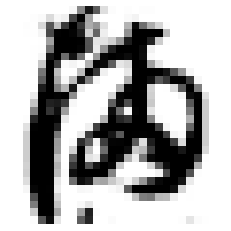

In [13]:
display_sample(X_tr[0])

## Preprocessing and Pipeline Creation

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [15]:
pipe = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', SVC())
])
pipe

Pipeline(steps=[('scalar', StandardScaler()), ('svc', SVC())])

## Fit and Predictions

In [16]:
import time

In [17]:
start = time.time()
pipe.fit(X_tr, Y_tr)
stop = time.time()
print(f"{stop-start} seconds to train")

7717.932411193848 seconds to train


In [19]:
# save model
from joblib import dump, load
dump(pipe['svc'], f"svm-{dataset}.joblib")

['svm-k49.joblib']

In [20]:
start = time.time()
y_pred = pipe.predict(X_val)
stop = time.time()
print(f"{stop-start} seconds to predict")

2953.7638251781464 seconds to predict


In [21]:
print(classification_report(y_pred, Y_val, labels=[i for i in range(len(lookup_df))]))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      1063
           1       0.94      0.92      0.93      1025
           2       0.91      0.78      0.84      1165
           3       0.79      0.83      0.81       119
           4       0.89      0.88      0.89      1010
           5       0.78      0.84      0.81       928
           6       0.81      0.82      0.82       992
           7       0.87      0.84      0.85      1040
           8       0.80      0.62      0.70       984
           9       0.81      0.87      0.84       929
          10       0.83      0.92      0.87       900
          11       0.84      0.84      0.84       998
          12       0.80      0.77      0.79      1044
          13       0.68      0.81      0.74       572
          14       0.64      0.80      0.71       500
          15       0.83      0.81      0.82      1023
          16       0.90      0.91      0.90       413
          17       0.93    

## Analysis